In [327]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                         validation_split=.2,
                                                         horizontal_flip=True,
                                                         rotation_range=20)

In [14]:
example = datagen.flow_from_directory('./lfw-funneled/', class_mode='input').__next__()

Found 13233 images belonging to 1 classes.


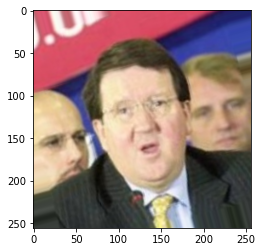

In [27]:
plt.imshow(example[0][1])

In [354]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU


def build_encoder(input_dim, output_dim, conv_layers, activation=LeakyReLU):
    encoder_input = Input(shape=input_dim, name='encoder_input')
    x = encoder_input
    
    for c, l in enumerate(conv_layers):
        x = Conv2D(l['filters'], l['k_size'], strides = l['strides'], 
                   padding='same', name='encoder_conv' + str(c))(x)
        x = activation(name='activation' + str(c))(x)
    
    shape_before_flattening = tf.keras.backend.int_shape(x)[1:] # skipping over batch dimension
    
    x = Flatten()(x)
    encoder_output = Dense(output_dim, name='encoder_output')(x)
    model = tf.keras.models.Model(encoder_input, encoder_output, name='encoder')
    
    return encoder_input, encoder_output, shape_before_flattening, model

def build_decoder(input_dim, shape_before_flattening, conv_layers, activation=LeakyReLU):
    decoder_input = Input(shape=(input_dim,), name='decoder_input')
    
    x = decoder_input
    
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = tf.keras.layers.Reshape(shape_before_flattening)(x)
    for c, l in enumerate(conv_layers):
        x = Conv2DTranspose(l['filters'], l['k_size'], l['strides'],
                           padding='same', name='decoder_conv_t' + str(c))(x)
        if c < len(conv_layers)-1:
            x = activation()(x)
        else:
            x = tf.keras.layers.Activation('sigmoid')(x)
    decoder_output = x
    
    return decoder_input, decoder_output, tf.keras.models.Model(decoder_input, decoder_output)

In [357]:
conv_layers = [{'filters': 32, 'k_size': 3, 'strides': 2},
              {'filters': 32, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2},
              {'filters': 64, 'k_size': 3, 'strides': 2}]

encoder_input, encoder_output, shape_before_flattening, encoder = build_encoder((256,256,3), 200, conv_layers)

deconv_layers = [{'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 64, 'k_size': 3, 'strides': 2},
                {'filters': 32, 'k_size': 3, 'strides': 2},
                {'filters': 3, 'k_size': 3, 'strides': 2}] # last one must have 3 filters to emulate the r,g,b channels

decoder_input, decoder_output, decoder = build_decoder(200, shape_before_flattening, deconv_layers)

In [358]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_conv0 (Conv2D)       (None, 128, 128, 32)      896       
_________________________________________________________________
activation0 (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 64, 64, 32)        9248      
_________________________________________________________________
activation1 (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 32, 32, 64)        18496     
_________________________________________________________________
activation2 (LeakyReLU)      (None, 32, 32, 64)        0   

In [359]:
decoder.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense_100 (Dense)            (None, 4096)              823296    
_________________________________________________________________
reshape_55 (Reshape)         (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t0 (Conv2DTrans (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_t1 (Conv2DTrans (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0  

In [360]:
simple_ae_input = encoder_input
simple_ae_output = decoder(encoder_output)

ae = tf.keras.models.Model(inputs=simple_ae_input, outputs=simple_ae_output, name='AE')
ae.compile(optimizer='adam', loss='mse')
ae.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_conv0 (Conv2D)       (None, 128, 128, 32)      896       
_________________________________________________________________
activation0 (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
encoder_conv1 (Conv2D)       (None, 64, 64, 32)        9248      
_________________________________________________________________
activation1 (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv2 (Conv2D)       (None, 32, 32, 64)        18496     
_________________________________________________________________
activation2 (LeakyReLU)      (None, 32, 32, 64)        0        

In [361]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_7-25.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [362]:
train_generator = datagen.flow_from_directory('./lfw-funneled/lfw_funneled', shuffle=True, seed=1337, subset='training', class_mode='input')
test_generator = datagen.flow_from_directory('./lfw-funneled/lfw_funneled', shuffle=True, seed=1337, subset='validation', class_mode='input')

Found 12161 images belonging to 5749 classes.
Found 1072 images belonging to 5749 classes.


((256, 256, 3), (256, 256, 3))

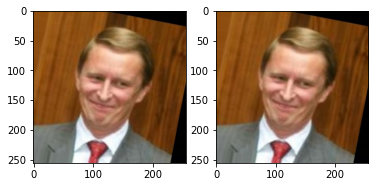

In [363]:
val = test_generator.__next__()
plt.subplot(121)
plt.imshow(val[0][0])
plt.subplot(122)
plt.imshow(val[1][0])
(val[0][0].shape, val[1][0].shape)

In [364]:
tf.config.list_physical_devices('GPU')

[]

In [365]:
ae.fit(train_generator, batch_size=128,
      validation_data=test_generator, initial_epoch=0,
      epochs=30, callbacks=[early_stop, checkpoint])

Epoch 1/30
381/381 [==============================] - ETA: 0s - loss: 0.0307
Epoch 00001: val_loss improved from inf to 0.01545, saving model to best_7-25.h5
381/381 [==============================] - 585s 2s/step - loss: 0.0307 - val_loss: 0.0155
Epoch 2/30
381/381 [==============================] - ETA: 0s - loss: 0.0131
Epoch 00002: val_loss improved from 0.01545 to 0.01066, saving model to best_7-25.h5
381/381 [==============================] - 819s 2s/step - loss: 0.0131 - val_loss: 0.0107
Epoch 3/30
381/381 [==============================] - ETA: 0s - loss: 0.0101
Epoch 00003: val_loss improved from 0.01066 to 0.00913, saving model to best_7-25.h5
381/381 [==============================] - 613s 2s/step - loss: 0.0101 - val_loss: 0.0091
Epoch 4/30
381/381 [==============================] - ETA: 0s - loss: 0.0091
Epoch 00004: val_loss improved from 0.00913 to 0.00839, saving model to best_7-25.h5
381/381 [==============================] - 734s 2s/step - loss: 0.0091 - val_loss: 0.0

In [366]:
tf.keras.models.save_model(ae, 'best_7-25.h5')

(256, 256, 3)

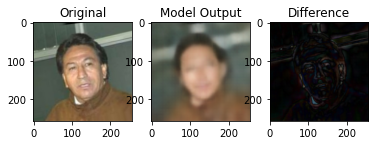

In [367]:
img = np.array(val[0][14])
img_reshaped = img.reshape((1,256,256,3))
prediction = ae.predict(img_reshaped)
plt.subplot(131)
plt.title('Original')
plt.imshow(img)
plt.subplot(132)
plt.title('Model Output')
plt.imshow(prediction[0])
plt.subplot(133)
plt.title('Difference')
plt.imshow(np.abs(img-prediction[0]))
img.shape

In [285]:
encoder = tf.keras.models.Model(inputs=input_layer, outputs=ae.get_layer(name='latent').output)
encoder.summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 127, 127, 3)       84        
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 63, 63, 3)         0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 31, 31, 16)        448       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 15, 15, 16)        0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 3600)              0         
_________________________________________________________________
latent (Dense)               (None, 256)               921

In [286]:
coding_vector = encoder.predict(img_reshaped)
coding_vector

array([[0.41447031, 0.36400494, 0.28142637, 0.19334915, 0.39098442,
        0.45840126, 0.5915606 , 0.32837576, 0.05309853, 0.00957632,
        0.2515425 , 0.37944874, 0.20442429, 0.49183667, 0.02166632,
        0.34769353, 0.06901142, 0.11926541, 0.13596377, 0.442705  ,
        0.32271564, 0.8938266 , 0.25527057, 0.2907401 , 0.37205982,
        0.02647439, 0.40136123, 0.37120467, 0.24556643, 0.5910669 ,
        0.35664302, 0.2240932 , 0.3063534 , 0.368618  , 0.34151804,
        0.3700504 , 0.26194954, 0.59603286, 0.30281603, 0.00501275,
        0.5689029 , 0.04640919, 0.46052998, 0.01926205, 0.00357562,
        0.306148  , 0.17039478, 0.37573227, 0.24485868, 0.3751312 ,
        0.64051276, 0.3539771 , 0.07957315, 0.44882327, 0.46457002,
        0.4671204 , 0.48775387, 0.17665353, 0.46288678, 0.04457304,
        0.02450132, 0.56783104, 0.03187516, 0.33229086, 0.61460483,
        0.24516356, 0.5925004 , 0.52549416, 0.21897867, 0.3751309 ,
        0.25456214, 0.8296325 , 0.38371077, 0.33

(256, 256, 3)

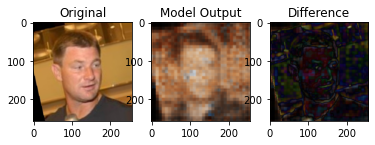

In [293]:
img2 = np.array(val[0][8])
img_reshaped2 = img2.reshape((1,256,256,3))
prediction = ae.predict(img_reshaped2)
plt.subplot(131)
plt.title('Original')
plt.imshow(img2)
plt.subplot(132)
plt.title('Model Output')
plt.imshow(prediction[0])
plt.subplot(133)
plt.title('Difference')
plt.imshow(np.abs(img2-prediction[0]))
img2.shape

In [288]:
coding_vector2 = encoder.predict(img_reshaped2)
coding_vector2

array([[0.4761842 , 0.43570516, 0.43416527, 0.17875507, 0.5114434 ,
        0.2239067 , 0.34228534, 0.42326075, 0.16865933, 0.03983992,
        0.2833717 , 0.3215335 , 0.3429168 , 0.3093089 , 0.01951453,
        0.593413  , 0.12488768, 0.43774286, 0.26320583, 0.5702418 ,
        0.7643193 , 0.7211385 , 0.41211596, 0.7270837 , 0.31586114,
        0.11485699, 0.14572427, 0.33882618, 0.39792645, 0.8085699 ,
        0.3926203 , 0.6735614 , 0.48920298, 0.7034707 , 0.23835853,
        0.7066568 , 0.29839528, 0.69967127, 0.46813345, 0.0056183 ,
        0.37399867, 0.28837755, 0.47060832, 0.01839751, 0.00476706,
        0.42892247, 0.4512389 , 0.75360966, 0.5344202 , 0.3882942 ,
        0.6999769 , 0.44554985, 0.13809758, 0.5702612 , 0.64790154,
        0.5814303 , 0.46257365, 0.18724525, 0.22100204, 0.16659087,
        0.10172915, 0.4458779 , 0.08630133, 0.23993582, 0.2528298 ,
        0.39033172, 0.40095085, 0.4016239 , 0.3549075 , 0.5527107 ,
        0.24859911, 0.5743207 , 0.58058137, 0.75

In [290]:
np.mean(coding_vector - coding_vector2)

-0.047534354